<a href="https://colab.research.google.com/github/robertobruzzese/article-lab/blob/main/Progetto_con_Debugger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Debugger



In [ ]:
def factorial(x):
  if(x == 0):
    return 1
  return x * factorial(x-1)

In [ ]:
factorial(4)

24

In [ ]:
import random

In [ ]:
def code_to_debug():
  import pdb; pdb.set_trace()
  
  for i in range(10):
    x = random.random()
    factorial(x)

In [ ]:
code_to_debug()

> <ipython-input-7-945f68572b59>(4)code_to_debug()
-> for i in range(10):
(Pdb) ?

Documented commands (type help <topic>):
EOF    c          d        h         list      q        rv       undisplay
a      cl         debug    help      ll        quit     s        unt      
alias  clear      disable  ignore    longlist  r        source   until    
args   commands   display  interact  n         restart  step     up       
b      condition  down     j         next      return   tbreak   w        
break  cont       enable   jump      p         retval   u        whatis   
bt     continue   exit     l         pp        run      unalias  where    

Miscellaneous help topics:
exec  pdb

(Pdb) help c
c(ont(inue))
        Continue execution, only stop when a breakpoint is encountered.
(Pdb) l
  1  	def code_to_debug():
  2  	  import pdb; pdb.set_trace()
  3  	
  4  ->	  for i in range(10):
  5  	    x = random.random()
  6  	    factorial(x)
[EOF]
(Pdb) n
> <ipython-input-7-945f68572b59>(5)code

RecursionError: ignored

In [ ]:
code_to_debug()

> <ipython-input-7-945f68572b59>(4)code_to_debug()
-> for i in range(10):
(Pdb) n
> <ipython-input-7-945f68572b59>(5)code_to_debug()
-> x = random.random()
(Pdb) n
> <ipython-input-7-945f68572b59>(6)code_to_debug()
-> factorial(x)
(Pdb) help step
s(tep)
        Execute the current line, stop at the first possible occasion
        (either in a function that is called or in the current
        function).
(Pdb) s
--Call--
> <ipython-input-1-0d734333151a>(1)factorial()
-> def factorial(x):
(Pdb) n
> <ipython-input-1-0d734333151a>(2)factorial()
-> if(x == 0):
(Pdb) n
> <ipython-input-1-0d734333151a>(4)factorial()
-> return x * factorial(x-1)
(Pdb) print(x)
0.3587771444907527
(Pdb) print(x-1)
-0.6412228555092473
(Pdb) s
--Call--
> <ipython-input-1-0d734333151a>(1)factorial()
-> def factorial(x):
(Pdb) print(x)
-0.6412228555092473
(Pdb) quit


BdbQuit: ignored

In [ ]:
def factorial_debugged(x):
  if (not isinstance(x,int)):
    print('this is not int')
    return -1
  if(x == 0):
    return 1
  return x * factorial(x-1)

In [ ]:
def code_to_debug():
  import pdb; pdb.set_trace()
  
  for i in range(10):
    x = random.random()
    factorial_debugged(x)

In [ ]:
code_to_debug()

> <ipython-input-13-3364bd0836cb>(4)code_to_debug()
-> for i in range(10):
(Pdb) c
this is not int
this is not int
this is not int
this is not int
this is not int
this is not int
this is not int
this is not int
this is not int
this is not int


### using xmode


In [ ]:
def factorial_debugged(x):
  if(x == 0):
    return 1
  return x * factorial(x-1)

In [ ]:
%xmode Verbose

Exception reporting mode: Verbose


In [ ]:
def code_to_debug():
  #import pdb; pdb.set_trace()
  
  for i in range(10):
    x = random.random()
    factorial_debugged(x)

In [ ]:
code_to_debug()

RecursionError: ignored

In [2]:
pip install einops

In [3]:
import torch
import torch.nn as nn

from einops import rearrange
from einops.layers.torch import Rearrange


def conv_3x3_bn(inp, oup, image_size, downsample=False):
    stride = 1 if downsample == False else 2
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.GELU()
    )


class PreNorm(nn.Module):
    def __init__(self, dim, fn, norm):
        super().__init__()
        self.norm = norm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


class SE(nn.Module):
    def __init__(self, inp, oup, expansion=0.25):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(oup, int(inp * expansion), bias=False),
            nn.GELU(),
            nn.Linear(int(inp * expansion), oup, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)


class MBConv(nn.Module):
    def __init__(self, inp, oup, image_size, downsample=False, expansion=4):
        super().__init__()
        self.downsample = downsample
        stride = 1 if self.downsample == False else 2
        hidden_dim = int(inp * expansion)

        if self.downsample:
            self.pool = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        if expansion == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride,
                          1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                # down-sample in the first conv
                nn.Conv2d(inp, hidden_dim, 1, stride, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, 1, 1,
                          groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.GELU(),
                SE(inp, hidden_dim),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        
        self.conv = PreNorm(inp, self.conv, nn.BatchNorm2d)

    def forward(self, x):
        if self.downsample:
            return self.proj(self.pool(x)) + self.conv(x)
        else:
            return x + self.conv(x)


class Attention(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, dropout=0.):
        super().__init__()
        inner_dim = dim_head * heads
        project_out = not (heads == 1 and dim_head == inp)

        self.ih, self.iw = image_size

        self.heads = heads
        self.scale = dim_head ** -0.5

        # parameter table of relative position bias
        self.relative_bias_table = nn.Parameter(
            torch.zeros((2 * self.ih - 1) * (2 * self.iw - 1), heads))

        coords = torch.meshgrid((torch.arange(self.ih), torch.arange(self.iw)))
        coords = torch.flatten(torch.stack(coords), 1)
        relative_coords = coords[:, :, None] - coords[:, None, :]

        relative_coords[0] += self.ih - 1
        relative_coords[1] += self.iw - 1
        relative_coords[0] *= 2 * self.iw - 1
        relative_coords = rearrange(relative_coords, 'c h w -> h w c')
        relative_index = relative_coords.sum(-1).flatten().unsqueeze(1)
        self.register_buffer("relative_index", relative_index)

        self.attend = nn.Softmax(dim=-1)
        self.to_qkv = nn.Linear(inp, inner_dim * 3, bias=False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, oup),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim=-1)
        q, k, v = map(lambda t: rearrange(
            t, 'b n (h d) -> b h n d', h=self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        # Use "gather" for more efficiency on GPUs
        relative_bias = self.relative_bias_table.gather(
            0, self.relative_index.repeat(1, self.heads))
        relative_bias = rearrange(
            relative_bias, '(h w) c -> 1 c h w', h=self.ih*self.iw, w=self.ih*self.iw)
        dots = dots + relative_bias

        attn = self.attend(dots)
        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out = self.to_out(out)
        return out


class Transformer(nn.Module):
    def __init__(self, inp, oup, image_size, heads=8, dim_head=32, downsample=False, dropout=0.):
        super().__init__()
        hidden_dim = int(inp * 4)

        self.ih, self.iw = image_size
        self.downsample = downsample

        if self.downsample:
            self.pool1 = nn.MaxPool2d(3, 2, 1)
            self.pool2 = nn.MaxPool2d(3, 2, 1)
            self.proj = nn.Conv2d(inp, oup, 1, 1, 0, bias=False)

        self.attn = Attention(inp, oup, image_size, heads, dim_head, dropout)
        self.ff = FeedForward(oup, hidden_dim, dropout)

        self.attn = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(inp, self.attn, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

        self.ff = nn.Sequential(
            Rearrange('b c ih iw -> b (ih iw) c'),
            PreNorm(oup, self.ff, nn.LayerNorm),
            Rearrange('b (ih iw) c -> b c ih iw', ih=self.ih, iw=self.iw)
        )

    def forward(self, x):
        if self.downsample:
            x = self.proj(self.pool1(x)) + self.attn(self.pool2(x))
        else:
            x = x + self.attn(x)
        x = x + self.ff(x)
        return x


class CoAtNet(nn.Module):
    def __init__(self, image_size, in_channels, num_blocks, channels, num_classes=1000, block_types=['C', 'C', 'T', 'T']):
        super().__init__()
        ih, iw = image_size
        block = {'C': MBConv, 'T': Transformer}

        self.s0 = self._make_layer(
            conv_3x3_bn, in_channels, channels[0], num_blocks[0], (ih // 2, iw // 2))
        self.s1 = self._make_layer(
            block[block_types[0]], channels[0], channels[1], num_blocks[1], (ih // 4, iw // 4))
        self.s2 = self._make_layer(
            block[block_types[1]], channels[1], channels[2], num_blocks[2], (ih // 8, iw // 8))
        self.s3 = self._make_layer(
            block[block_types[2]], channels[2], channels[3], num_blocks[3], (ih // 16, iw // 16))
        self.s4 = self._make_layer(
            block[block_types[3]], channels[3], channels[4], num_blocks[4], (ih // 32, iw // 32))

        self.pool = nn.AvgPool2d(ih // 32, 1)
        self.fc = nn.Linear(channels[-1], num_classes, bias=False)

    def forward(self, x):
        x = self.s0(x)
        x = self.s1(x)
        x = self.s2(x)
        x = self.s3(x)
        x = self.s4(x)

        x = self.pool(x).view(-1, x.shape[1])
        x = self.fc(x)
        return x

    def _make_layer(self, block, inp, oup, depth, image_size):
        layers = nn.ModuleList([])
        for i in range(depth):
            if i == 0:
                layers.append(block(inp, oup, image_size, downsample=True))
            else:
                layers.append(block(oup, oup, image_size))
        return nn.Sequential(*layers)


def coatnet_0():
    num_blocks = [2, 2, 3, 5, 2]            # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=3)


def coatnet_1():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [64, 96, 192, 384, 768]      # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_2():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [128, 128, 256, 512, 1026]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_3():
    num_blocks = [2, 2, 6, 14, 2]           # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def coatnet_4():
    num_blocks = [2, 2, 12, 28, 2]          # L
    channels = [192, 192, 384, 768, 1536]   # D
    return CoAtNet((224, 224), 3, num_blocks, channels, num_classes=1000)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


if __name__ == '__main__':
    img = torch.randn(1, 3, 224, 224)

    net = coatnet_0()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_1()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_2()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_3()
    out = net(img)
    print(out.shape, count_parameters(net))

    net = coatnet_4()
    out = net(img)
    print(out.shape, count_parameters(net))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([1, 3]) 17023928
torch.Size([1, 1000]) 33170624
torch.Size([1, 1000]) 55767564
torch.Size([1, 1000]) 117724480
torch.Size([1, 1000]) 203960368


In [4]:
import matplotlib.pyplot as plt
import numpy as np 
import os


import torch # PyTorch package
import torchvision # load datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid


from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, Dropout

import torchvision.transforms as transforms #  agument data
import torch.nn as nn #  building  neural neteorks
import torch.nn.functional as F #  convolution functions like Relu
import torch.optim as optim # optimzer 
from torchsummary import summary

In [5]:
train_root='./dataset_9010/dataset_9010/malimg_dataset/train'
val_root='./validation_ds_update_924/validation_ds_update_924/malimg_dataset/validation'

In [6]:
data_aug_transforms = [
     transforms.RandomHorizontalFlip(), 
     transforms.RandomVerticalFlip(p=0.5),
     transforms.RandomAffine(degrees=75),
     transforms.RandomAffine(degrees=0,translate=(0.5,0.5)),
     transforms.RandomAffine(degrees=0,scale=(0.7,0.7))
 ]

In [7]:
from google.colab import drive

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
cd '/content/drive/MyDrive/AML_DATA/'

/content/drive/.shortcut-targets-by-id/1PHQ0lh7VNfUJjD9R69bWwquzSpqaGt3s/AML_DATA


In [10]:
img_size=(64, 64)

data_transform=transforms.Compose(
     data_aug_transforms+
   [ transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
   ])
# mean and std are calculated from the ImageNet images



orig_set = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_= torchvision.datasets.ImageFolder(root=val_root )


n = len(orig_set)  # total number of examples


print(f'Number of original examples: {len(orig_set)}')
print(f'Number of Validation examples: {len(val_)}')

print("Number of classes in training set : \n", len(orig_set.classes))
print("The follwing classes are in training set : \n",orig_set.classes)

Number of original examples: 8404
Number of Validation examples: 924
Number of classes in training set : 
 25
The follwing classes are in training set : 
 ['Adialer.C', 'Agent.FYI', 'Allaple.A', 'Allaple.L', 'Alueron.gen!J', 'Autorun.K', 'C2LOP.P', 'C2LOP.gen!g', 'Dialplatform.B', 'Dontovo.A', 'Fakerean', 'Instantaccess', 'Lolyda.AA1', 'Lolyda.AA2', 'Lolyda.AA3', 'Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen', 'Skintrim.N', 'Swizzor.gen!E', 'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']


In [11]:
train_dataset = torchvision.datasets.ImageFolder(root=train_root , transform=data_transform )
val_dataset = torchvision.datasets.ImageFolder(root=val_root , transform=data_transform)

print(f'Number of training examples: {len(train_dataset)}')
print(f'Number of Validation examples: {len(val_dataset)}')

batch_size = 32
train_loader=DataLoader(train_dataset,batch_size=batch_size , shuffle=True )
val_loader=DataLoader(val_dataset,batch_size=batch_size ,shuffle=False)

Number of training examples: 8404
Number of Validation examples: 924


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)


input_size = 3
num_classes = 25
num_epochs = 20
batch_size = 32
learning_rate = 2e-3
learning_rate_decay = 0.95
reg=0.001
num_training= 8404
num_validation =924


# Train the model
lr = learning_rate
total_step = len(train_loader)
loss_train = []
loss_val = []
accuracy_val = []
train_acc_curve=[]


num_blocks = [2, 2, 6, 8, 2]
channels = [16, 32, 64, 128, 256]
block_types = ['C', 'C', 'T', 'T']

model_ = CoAtNet((64,64),3,num_blocks=num_blocks, channels=channels, block_types=block_types, num_classes=25).to(device)

optimizer = torch.optim.Adam(model_.parameters(), lr=learning_rate, weight_decay=reg)
criterion = nn.CrossEntropyLoss()

Using device: cpu


In [14]:
def weights_init(m):
    if type(m) == nn.Linear:
        m.weight.data.normal_(0.0, 1e-3)
        m.bias.data.fill_(0.)

def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

Epoch [1/20], Step [100/263], Loss: 0.9815
Epoch [1/20], Step [200/263], Loss: 0.8483
Training accuracy is: 71.25178486435031 %
Validation accuracy is: 54.112554112554115 %
Epoch [2/20], Step [100/263], Loss: 1.0649
Epoch [2/20], Step [200/263], Loss: 0.9213
Training accuracy is: 75.67824845311756 %
Validation accuracy is: 62.01298701298701 %
Epoch [3/20], Step [100/263], Loss: 0.6280
Epoch [3/20], Step [200/263], Loss: 0.5384
Training accuracy is: 78.1413612565445 %
Validation accuracy is: 57.35930735930736 %
Epoch [4/20], Step [100/263], Loss: 0.7737
Epoch [4/20], Step [200/263], Loss: 0.3833
Training accuracy is: 78.36744407425036 %
Validation accuracy is: 64.6103896103896 %
Epoch [5/20], Step [100/263], Loss: 0.9426
Epoch [5/20], Step [200/263], Loss: 0.7619
Training accuracy is: 81.4017134697763 %
Validation accuracy is: 58.54978354978355 %
Epoch [6/20], Step [100/263], Loss: 0.6873
Epoch [6/20], Step [200/263], Loss: 0.3601
Training accuracy is: 83.30556877677297 %
Validation acc

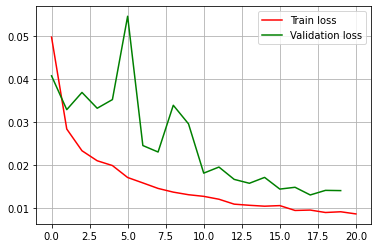

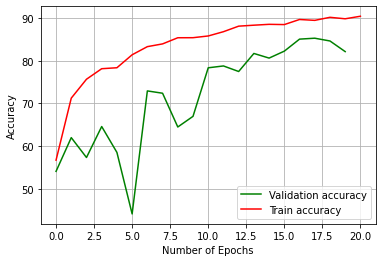

In [15]:
for epoch in range(num_epochs):
    correct = 0
    total = 0

    model_.train()

    loss_iter = 0
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model_(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        ###
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        ###

        loss_iter += loss.item()
        
        if (i+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    loss_train.append(loss_iter/(len(train_loader)*batch_size))
    
    ###
    _train_acc = 100 * correct / total
    train_acc_curve.append(_train_acc)
    print('Training accuracy is: {} %'.format(_train_acc))
    ###


    
    # Code to update the lr
    lr *= learning_rate_decay
    update_lr(optimizer, lr)
    
    
    
     
    model_.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        loss_iter = 0
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            loss = criterion(outputs, labels)
            loss_iter += loss.item()
        
        loss_val.append(loss_iter/(len(val_loader)*batch_size))

        accuracy = 100 * correct / total
        accuracy_val.append(accuracy)
        print('Validation accuracy is: {} %'.format(accuracy))
        


    


model_.eval()



plt.figure(2)
plt.plot(loss_train, 'r', label='Train loss')
plt.plot(loss_val, 'g', label='Validation loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(3)
plt.plot(accuracy_val, 'g', label='Validation accuracy')
plt.plot(train_acc_curve, 'r', label='Train accuracy')
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()